In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from collections import Counter

In [21]:
def load_nli_data(path):
    """
    Load MultiNLI or SNLI data.
    """
    LABEL_MAP = {
    "entailment": 0,
    "neutral": 1,
    "contradiction": 2}
    
    data = []
    with open(path) as f:
        for line in f:
            loaded_example = json.loads(line)
            if loaded_example["gold_label"] not in LABEL_MAP:
                continue
            loaded_example["label"] = LABEL_MAP[loaded_example["gold_label"]]
            data.append(loaded_example)
            
        # really cannot change this random seed
        random.seed(1)
        random.shuffle(data)
        
    return data

In [110]:
# get the fraction of annotator labels that are majority
# get most common label, then divide its count by number of labels total
def get_majority_frac(row):
    maj_frac = Counter(row['annotator_labels']).most_common()[0][1]/len(row['annotator_labels'])
    return maj_frac


# identify premises that have many flip classes
# get all rows by a generation, count number of uncertains, get fraction over all generations.

def get_uncertain_frac(row):
    flip_counter = Counter(df.loc[df['line-num'] == row['line-num']]['flip-class'])

    uncertain_count = 0
    if flip_counter.get('Uncertain-Same'):
        uncertain_count += flip_counter.get('Uncertain-Same') 
    if flip_counter.get('Uncertain-Flip'):
        uncertain_count += flip_counter.get('Uncertain-Flip') 

    # number of uncertain generations over total number of generations
    uncertain_frac = uncertain_count / sum(flip_counter.values())
    
    return uncertain_frac

In [172]:
MNLI = pd.DataFrame(load_nli_data('../data/MNLI/original/multinli_1.0_dev_matched.jsonl'))
MNLI['line-num'] = MNLI.index
MNLI.shape

(9815, 13)

In [135]:
df = pd.read_csv('../output/MNLI/cleaned_10000_fine-tuned_gradient_gold-label_beam_MNLI_dev_labeled.csv')
df.shape

(29991, 28)

In [184]:
MNLI['agreement'] = MNLI.apply(lambda row : get_majority_frac(row), axis = 1)
df['uncertain_frac'] = df.apply(lambda row : get_uncertain_frac(row), axis = 1)

In [185]:
m_df = pd.merge(df, MNLI[['line-num', 'agreement']], left_on = 'line-num', right_on = 'line-num')
m_df = m_df.drop_duplicates('line-num')
print(f'There are: {len(m_df["line-num"].unique())} premises generated over.')

There are: 2581 premises generated over.


In [193]:
m_df['unc_gen'] = 0
m_df.loc[m_df['uncertain_frac'] > 0.25, 'unc_gen'] = 1
m_df.loc[m_df['uncertain_frac'] > 0.5, 'unc_gen'] = 2
m_df.loc[m_df['uncertain_frac'] > 0.75, 'unc_gen'] = 3

array([[<AxesSubplot:title={'center':'uncertain_frac'}>]], dtype=object)

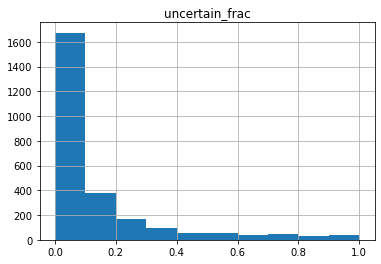

In [215]:
m_df.hist('uncertain_frac')

In [214]:
metric = m_df.groupby(['unc_gen', 'agreement']).agg({'agreement': ['count']})
metric['agreement']['count']
metric['Fraction'] = round(metric.groupby(level='unc_gen').transform(lambda x: x/x.sum())*100,1)
metric

agreement Fraction
                      count         
unc_gen agreement                   
0       0.6             270     12.5
        0.8             506     23.3
        1.0            1392     64.2
1       0.6              61     27.6
        0.8              68     30.8
        1.0              92     41.6
2       0.6              38     34.9
        0.8              32     29.4
        1.0              39     35.8
3       0.6              32     38.6
        0.8              26     31.3
        1.0              25     30.1

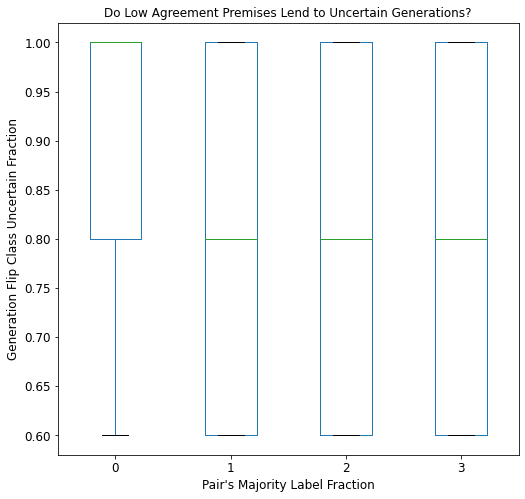

In [194]:
box = m_df.boxplot(column = ['agreement'], by = 'unc_gen', figsize = (8,8), grid=False, fontsize = 'large')
box.set_xlabel("Pair's Majority Label Fraction", fontsize = 'large')
box.set_ylabel('Generation Flip Class Uncertain Fraction', fontsize = 'large')
box.set_title('Do Low Agreement Premises Lend to Uncertain Generations?')
plt.suptitle('') 
plt.savefig('../graphs/Uncertain-Agreement.png', dpi = 200)

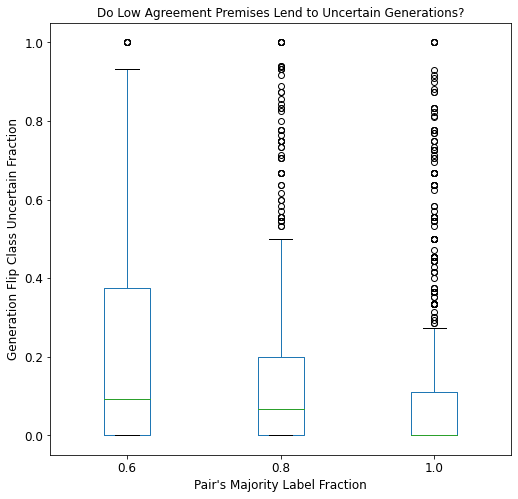

In [186]:
box = m_df.boxplot(column = ['uncertain_frac'], by = 'agreement', figsize = (8,8), grid=False, fontsize = 'large')
box.set_xlabel("Pair's Majority Label Fraction", fontsize = 'large')
box.set_ylabel('Generation Flip Class Uncertain Fraction', fontsize = 'large')
box.set_title('Do Low Agreement Premises Lend to Uncertain Generations?')
plt.suptitle('') 
plt.savefig('../graphs/Agreement-Uncertain.png', dpi = 200)